# Project CodeNet Language Classification

> Copyright (c) 2021 International Business Machines Corporation  
Prepared by [Geert Janssen](geert@us.ibm.com>)

## Introduction

This notebook takes you through the steps of a simple experiment that shows
how to create and exercise a Keras model to detect the language of a piece of
source code. We will be using TensorFlow as its backend.
For convenience, all the necessary steps will be in this single notebook.
One might want to factor out some parts and put them in separate Python files
for training, testing and inference.

Let's start with a few obligatory imports:

In [1]:
import os
import numpy as np
import re
import requests
import tarfile
import shutil

## Approach

Classification means determining the class a given sample belongs to. In our
case we want to determine the programming language in which a given piece of code
is written. There are many different ways of solving this problem. Here we
choose a neural network approach where we train a convolutional model to do
our bidding. The input will be a sample of source code and the output is an
indication of its language.

We will treat the input at the character level. We will assume that the input
source file is mostly ASCII characters and the input to the neural network is
an encoding of a small, fixed set of characters.

In [2]:
letter = 'abcdefghijklmnopqrstuvwxyz'
digits = '0123456789'
others = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
alphabet = letter + digits + others
print('alphabet size:', len(alphabet))

# all-zeroes padding vector:
pad_vector = [0 for x in alphabet]

# pre-calculated one-hot vectors:
supported_chars_map = {}

for i, ch in enumerate(alphabet):
  vec = [0 for x in alphabet]
  vec[i] = 1
  supported_chars_map[ch] = vec

print('one-hot encoding for character c:', supported_chars_map['c'])

alphabet size: 68
one-hot encoding for character c: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Data

For simplicity and to keep the (training) run-time within reasonable bounds, we
use a selection of source files from Project CodeNet written in 10 different
languages. For each language we select a 100 files of a size of at least 1000
bytes but no larger than 5000 bytes. For each language, 10 files out the 100
are set aside for testing the model.

### Download and extract


The data is available as a gzipped tar file `Project_CodeNet_LangClass.tgz`.
The directory structure is `data/train/<language>/<source>` and
`data/test/<language>/<source>`. Let's download the data and store it on the
local filesystem:

In [3]:
file_name = "Project_CodeNet_LangClass.tar.gz"
data_url = f"https://dax-cdn.cdn.appdomain.cloud/dax-project-codenet/1.0.0/{file_name}"

# Download tar archive to local disk
with open(file_name, "wb") as f:
    f.write(requests.get(data_url).content)
    
# Extract contents of archive to local disk
if os.path.exists("data"):
    shutil.rmtree("data")    
with tarfile.open(file_name) as tf:
    tf.extractall()

In [4]:
!ls data data/train

data:
test  train

data/train:
C          C++        Haskell    JavaScript Python
C#         D          Java       PHP        Rust


The 10 programming languages are C, C#, C++, D, Haskell, Java, JavaScript, PHP,
Python, and Rust. Note that some languages belong to the same family: C, C++,
and D are very close in lexical elements and syntax.

In [5]:
langs = [
  "C",
  "C#",
  "C++",
  "D",
  "Haskell",
  "Java",
  "JavaScript",
  "PHP",
  "Python",
  "Rust"
]

num_classes = len(langs)

### Read a file and create samples

Since the source files are of varying size and we want fixed length samples,
simply truncating each file might bias the training to artifacts that
typically only appear at the beginning of a file, such as copyrights statements
and documentation or class and type definitions. We would probably get more
interesting samples when we chunk each file. Here we split each file in 3
parts based on the number of lines. Only then the parts will be truncated or
padded as needed. This means that the number of samples is no longer equal to
the number of files but up to 3 times as large.

In [6]:
def get_source_snippets(file_name, breakup=True):
  # Read the file content and lower-case:                                    
  text = ""
  with open(file_name, mode='r') as file:
    text = file.read().lower()
  lines = text.split('\n')
  nlines = len(lines)
  if breakup and nlines > 50:
    aThird = nlines//3
    twoThirds = 2*aThird
    text1 = '\n'.join(lines[:aThird])
    text2 = '\n'.join(lines[aThird:twoThirds])
    text3 = '\n'.join(lines[twoThirds:])
    return [text1, text2, text3]
  return [text]

To see the effect of `get_source_snippets` let's run it on a single train file:

In [7]:
get_source_snippets('data/train/Haskell/s084836192.hs', breakup=True)

['import control.applicative\nimport control.monad\nimport control.monad.st\n-- import qualified data.bytestring as bs\nimport data.functor\nimport data.function\nimport data.monoid\nimport data.maybe\nimport data.list\nimport qualified data.foldable as foldable\nimport qualified data.set as set\n--import qualified data.sequence as sequence\nimport data.list.split\nimport data.bits\nimport data.char\nimport data.ix\nimport data.ratio\nimport data.ord\nimport data.tuple\nimport data.array\n--import data.array.unboxed\n--import data.array.iarray\nimport data.array.marray\nimport data.array.io\nimport data.array.st\nimport data.ioref\nimport data.stref\nimport text.printf\nimport ghc.st',
 "-- import system.io.unsafe\n \n-- templete\nreadint = read :: string -> int\nreadinteger = read :: string -> integer\nreaddouble = read :: string -> double\ngetint = readln :: io int\ngetints = map readint . words <$> getline\ngetinteger = readln :: io integer\ngetintegers = map readinteger . words <$>

### Prepare training data as numpy arrays

Next we have to encode the snippets as one-hot vectors over the alphabet and
represent them as `numpy` arrays. Ultimately,
we do this for all files in a specified folder. But first the vectorization of a sample:

In [8]:
def turn_sample_to_vector(sample, sample_vectors_size=1024,
                          normalize_whitespace=True):
  if normalize_whitespace:
    # Map (most) white-space to space and compact to single one:
    sample = sample.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    sample = re.sub('\s+', ' ', sample)

  # Encode the characters to one-hot vectors:
  sample_vectors = []
  for ch in sample:
    if ch in supported_chars_map:
      sample_vectors.append(supported_chars_map[ch])

  # Truncate to fixed length:
  sample_vectors = sample_vectors[0:sample_vectors_size]

  # Pad with 0 vectors:
  if len(sample_vectors) < sample_vectors_size:
    for i in range(0, sample_vectors_size - len(sample_vectors)):
      sample_vectors.append(pad_vector)

  return np.array(sample_vectors)

In [9]:
sample = get_source_snippets('data/train/Haskell/s084836192.hs')[0]
vec = turn_sample_to_vector(sample, sample_vectors_size=10)
print('Encoded sample shape:', vec.shape)

Encoded sample shape: (10, 68)


Now do this for a whole file instead of a sample:

In [10]:
def turn_file_to_vectors(file_name, sample_vectors_size=1024,
                         normalize_whitespace=True, breakup=True):
  samples = get_source_snippets(file_name, breakup)
  return [turn_sample_to_vector(s, sample_vectors_size, normalize_whitespace)
          for s in samples]

Lastly, pair the vectorized samples with their class labels:

In [11]:
def get_input_and_labels(root_folder, sample_vectors_size=1024, breakup=True):
  X = []
  Y = []
  for i, lang in enumerate(langs):
    print('Processing language:', lang)
    # One-hot class label vector:
    class_label = [0 for x in range(0, num_classes)]
    class_label[i] = 1
    # For all files in language folder:
    folder = os.path.join(root_folder, lang)
    for fn in os.listdir(folder):
      if fn.startswith("."):
        continue  # Skip hidden files and Jupyterlab cache directories
      file_name = os.path.join(folder, fn)
      sample_vectors = turn_file_to_vectors(file_name,
                                            sample_vectors_size=sample_vectors_size,
                                            breakup=breakup)
      for fv in sample_vectors:
        X.append(fv)                 # the sample feature vector
        Y.append(class_label)        # the class ground-truth

  return np.array(X, dtype=np.int8), np.array(Y, dtype=np.int8)

Now we can get all the training data in numpy arrays. For good measure we shuffle all the samples. Notice that the number of samples turns out to be 2098; starting from 900 source files it is obvious that not every file is split in 3.

In [12]:
x, y = get_input_and_labels(root_folder='data/train')

# Shuffle data
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

print('samples shape', x_shuffled.shape)
print('class labels shape:', y_shuffled.shape)

Processing language: C
Processing language: C#
Processing language: C++
Processing language: D
Processing language: Haskell
Processing language: Java
Processing language: JavaScript
Processing language: PHP
Processing language: Python
Processing language: Rust
samples shape (2098, 1024, 68)
class labels shape: (2098, 10)


## Model

A (batch of) encoded sample(s) is simultaneously input to 3 slightly different
convolutional stages. Each stage consists of a 1-dimensional convolution
followed by a 1-dimensional max pooling layer topped off by a flattening layer.
The  kernel sizes of the stages are all different but the number of filters is
the same. The 3 stages are concatenated followed by 2 dense layers with a
dropout inbetween and lastly a softmax. The model summary does not show the nested model structure. `plot_model` however shows a nice graphical rendition of all the layers.

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate

# Model Hyperparameters
kernel_sizes = (3, 9, 19)
pooling_sizes = (3, 9, 19)
num_filters = 128
dropout_prob = 0.5
hidden_dims = 128

stage_in = Input(shape=(1024, 68))
convs = []
for i in range(0, len(kernel_sizes)):
  conv = Conv1D(filters=num_filters,
                kernel_size=kernel_sizes[i],
                padding='valid',
                activation='relu',
                strides=1)(stage_in)
  pool = MaxPooling1D(pool_size=pooling_sizes[i])(conv)
  flatten = Flatten()(pool)
  convs.append(flatten)

if len(kernel_sizes) > 1:
    out = Concatenate()(convs)
else:
    out = convs[0]

stages = Model(inputs=stage_in, outputs=out)

model = Sequential([
    stages,
    Dense(hidden_dims, activation='relu'),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax')
])

model.summary()

# Note: also need pydot and GraphViz installed for this.
#from tensorflow.keras.utils import plot_model                               
#plot_model(model, show_shapes=True, expand_nested=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64512)             270208    
_________________________________________________________________
dense (Dense)                (None, 128)               8257664   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 8,529,162
Trainable params: 8,529,162
Non-trainable params: 0
_________________________________________________________________


## Training

The 2098 samples with their ground truth (the class labels, i.e., the 10
languages) are fed into the model. This constitutes one so-called epoch. To
achieve a reasonable accuracy we have to train for several epochs. To speed
things up, the samples are bundled in batches.
Of the samples used in training, 10% are reserved for the validation step
after each epoch. In our case that leaves 1888 for training and given a batch
size of 64, one epoch then comprises some 30 batches.
First the model is compiled and then we train it. If possible you should execute the `fit` call using a GPU. Otherwise, sit back and get yourself a cup of coffee.

In [14]:
batch_size = 64
num_epochs = 20
val_split = 0.1

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
                    epochs=num_epochs, validation_split=val_split,
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 9s 272ms/step - loss: 3.2192 - accuracy: 0.1520 - val_loss: 2.1471 - val_accuracy: 0.2000
Epoch 2/20
30/30 [==============================] - 8s 250ms/step - loss: 2.0165 - accuracy: 0.2636 - val_loss: 1.9698 - val_accuracy: 0.3524
Epoch 3/20
30/30 [==============================] - 8s 254ms/step - loss: 1.8209 - accuracy: 0.3363 - val_loss: 1.4646 - val_accuracy: 0.6667
Epoch 4/20
30/30 [==============================] - 7s 250ms/step - loss: 1.3232 - accuracy: 0.5277 - val_loss: 0.8675 - val_accuracy: 0.8571
Epoch 5/20
30/30 [==============================] - 8s 252ms/step - loss: 0.9016 - accuracy: 0.6876 - val_loss: 0.5528 - val_accuracy: 0.8905
Epoch 6/20
30/30 [==============================] - 8s 250ms/step - loss: 0.6413 - accuracy: 0.7662 - val_loss: 0.3709 - val_accuracy: 0.9238
Epoch 7/20
30/30 [==============================] - 8s 254ms/step - loss: 0.4523 - accuracy: 0.8421 - val_loss: 0.2870 - val_accuracy: 0.9238
Epoch 

It is illustrative to chart the training process. The `history` contains all
the information that we need.

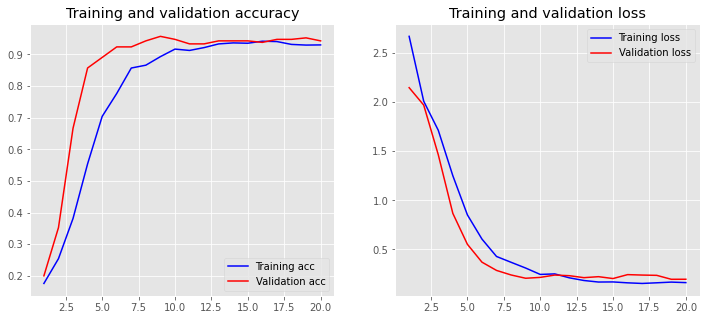

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

plot_history(history)

## Test

Finally, let's exercise our mint new model and see how it performs on a set of
samples hitherto unseen, in other words predict the language of the test set.
We re-use the `get_input_and_labels` and have it process all files in the
`test` directory. We predict the outcome of each sample and compare it against
the expected label (language).

In [16]:
x, y = get_input_and_labels(root_folder='data/test', breakup=False)
print('shape of test samples', x.shape)
y_hat = model.predict(x)

Processing language: C
Processing language: C#
Processing language: C++
Processing language: D
Processing language: Haskell
Processing language: Java
Processing language: JavaScript
Processing language: PHP
Processing language: Python
Processing language: Rust
shape of test samples (100, 1024, 68)


Here is a very simple evaluation of the model. For each language we count the number of correct prediction, i.e., the softmax output with the highest probability (viz. `argmax`):

In [17]:
hits = {}
for lang in langs:
  hits[lang] = 0

for i in range(len(x)):
  expected_lang  = langs[np.argmax(y[i], axis=0)]
  predicted_lang = langs[np.argmax(y_hat[i], axis=0)]
  if predicted_lang == expected_lang:
    hits[expected_lang] += 1

for lang in langs:
  print("%-10s: %3d correct" % (lang, hits[lang])) 

C         :   9 correct
C#        :  10 correct
C++       :   9 correct
D         :  10 correct
Haskell   :  10 correct
Java      :  10 correct
JavaScript:  10 correct
PHP       :  10 correct
Python    :  10 correct
Rust      :  10 correct


### Home work

Find out which test files are incorrectly predicted, and as what? Also, do a more thorough analysis and print the precision, recall, and F1 score of each class.

## Acknowledgement

The idea and much of the Python source code for this notebook was derived from the github https://github.com/aliostad/deep-learning-lang-detection by Ali Kheyrollahi.